In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

In [2]:
# method for importing the dataset
def import_dataset(filename):
    import pandas as pd
    dataset = pd.read_csv(filename)
    return dataset

In [3]:
# Data Preprocessing

train_df = import_dataset('sign_mnist_train.csv')
test_df = import_dataset('sign_mnist_test.csv')
    
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']
    
# Label Binarizer to reduce the processing speed. It is used to convert the labels into a matrix
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

x_train = train_df.values
x_test = test_df.values

# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

# Reshape the data
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [4]:
# model creation
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))

datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False, 
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

datagen.fit(x_train)


In [6]:
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (x_test, y_test))
# the model is saved in the file CSE572_DataMining.h5 and can be used for testing
model.save('CSE572_DataMining.h5')



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 75)        300       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 75)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 50)        

c:\Users\mohan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


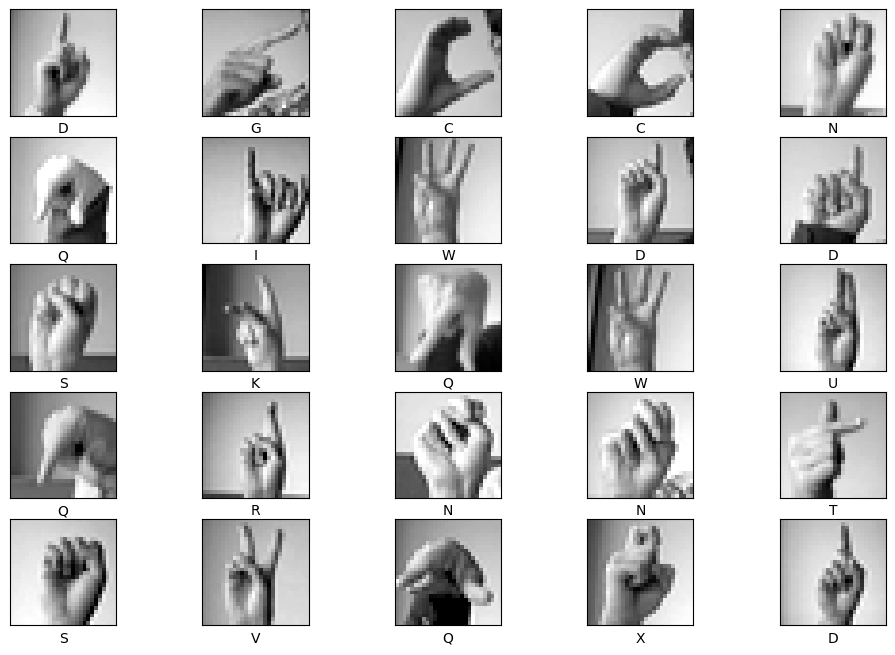

In [8]:
import matplotlib.pyplot as plt
import numpy as np
labels = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'K',10:'L',11:'M',12:'N',13:'O',14:'P',15:'Q',16:'R',17:'S',18:'T',19:'U',20:'V',21:'W',22:'X', 23:'Y'}

# visualize the Data along with the labels

plt.figure(figsize=(12,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i].reshape(28,28), cmap='gray')
    plt.xlabel(labels[np.argmax(y_train[i])])
plt.show()


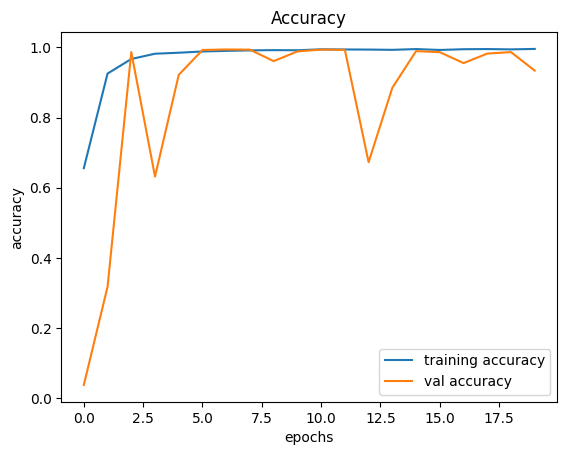

In [9]:
# plot the data set to see the distribution of the data
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()


In [10]:
import cv2
import numpy as np
from keras.models import load_model
import os

# load the model
model = load_model('CSE572_DataMining.h5')

# dictionary to map the labels
labels = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I', 9:'J', 10:'K', 11:'L', 12:'M', 13:'N', 14:'O', 15:'P', 16:'Q', 17:'R', 18:'S', 19:'T', 20:'U', 21:'V', 22:'W', 23:'X'}

# open the camera
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break
    frame = cv2.flip(frame, 1)
    # Draw the rectangle
    cv2.rectangle(frame, (100, 100), (700, 700), (255, 0, 0), 2)
    # Now extract the ROI using the frame itself
    roi = frame[100:400, 100:400]
    img = cv2.resize(roi, (28, 28))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.array(img)
    img = img.reshape(1, 28, 28, 1)
    img = img / 255.0
    pred = model.predict([img])
    cv2.putText(frame, labels[np.argmax(pred)], (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.imshow('Sign Language Detection', frame)
    k = cv2.waitKey(10)
    if k == 27:  # Esc key to stop
        break

# Close the camera and windows
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 25ms/step


In [ ]:
import cv2
import numpy as np
from keras.models import load_model
import os

# load the model
model = load_model('CSE572_DataMining.h5')

# dictionary to map the labels
labels = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I', 9:'J', 10:'K', 11:'L', 12:'M', 13:'N', 14:'O', 15:'P', 16:'Q', 17:'R', 18:'S', 19:'T', 20:'U', 21:'V', 22:'W', 23:'X'}

# open the camera
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break
    frame = cv2.flip(frame, 1)
    # Draw the rectangle
    cv2.rectangle(frame, (100, 100), (700, 700), (255, 0, 0), 2)
    # Now extract the ROI using the frame itself
    roi = frame[100:400, 100:400]
    img = cv2.resize(roi, (28, 28))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.array(img)
    img = img.reshape(1, 28, 28, 1)
    img = img / 255.0
    pred = model.predict([img])
    cv2.putText(frame, labels[np.argmax(pred)], (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.imshow('Sign Language Detection', frame)
    k = cv2.waitKey(10)
    if k == 27:  # Esc key to stop
        break

# Close the camera and windows
cap.release()
cv2.destroyAllWindows()

In [11]:
import cv2
import numpy as np
from keras.models import load_model
import os

# load the model
model = load_model('CSE572_DataMining.h5')

# dictionary to map the labels
labels = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I', 9:'K', 10:'L', 11:'M', 12:'N', 13:'O', 14:'P', 15:'Q', 16:'R', 17:'S', 18:'T', 19:'U', 20:'V', 21:'W', 22:'X', 23:'Y'}

# open the camera
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break
    frame = cv2.flip(frame, 1)
    # Draw a larger rectangle
    cv2.rectangle(frame, (50, 50), (650, 650), (255, 0, 0), 2)
    # Adjust the ROI to focus on the area within the rectangle
    roi = frame[50:650, 50:650]
    # Preprocessing for better gesture recognition
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    _, roi = cv2.threshold(roi, 120, 255, cv2.THRESH_BINARY)
    img = cv2.resize(roi, (28, 28))
    img = np.array(img)
    img = img.reshape(1, 28, 28, 1)
    img = img / 255.0
    pred = model.predict([img])
    cv2.putText(frame, labels[np.argmax(pred)], (10, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.imshow('Sign Language Detection', frame)
    k = cv2.waitKey(10)
    if k == 27:  # Esc key to stop
        break

# Close the camera and windows
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 21ms/step
